In [1]:
import pandas as pd
import numpy as np
import itertools
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm                                                   labelencoder   accuracy-auc   preds1- с новой строки
from statsmodels.tsa.arima_model import ARIMA                           roc auc не посчитать на бинарных пред1

plt.style.use('Solarize_Light2')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_percentage_error

Год_неделя
2018-01-07    5115.916556
2018-01-14    7274.487033
2018-01-21    5768.748778
2018-01-28    6995.499746
2018-02-04    6369.463776
                 ...     
2021-03-21       0.000000
2021-03-28       0.000000
2021-04-04       0.000000
2021-04-11       0.000000
2021-04-18       0.000000
Name: Отгруженный на клиента объем, тонн, Length: 172, dtype: float64

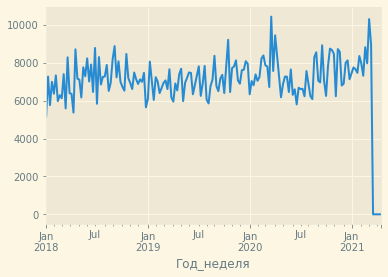

In [2]:
input_dir = 'C:/Users/vadim.sokolov/Desktop/В'
df = pd.read_excel(f'{input_dir}/test2/Задачи ML.xlsb', engine='pyxlsb', sheet_name='Задача 2', usecols=[0,1,2]).dropna()
#df.head()

df['Год_неделя'] = pd.to_datetime(
    df['Год'].astype(str) + '-W' + df['Неделя'].astype(str) + '-1', format='%G-W%V-%u').dt.strftime('%Y-%m-%d')
df = df[['Год_неделя', 'Отгруженный на клиента объем, тонн']]
df['Отгруженный на клиента объем, тонн'] = df['Отгруженный на клиента объем, тонн'].replace('?', 0)

df['Год_неделя'] = pd.to_datetime(df['Год_неделя'])
df = df.set_index('Год_неделя')
df.sort_index(inplace=True)
df = df['Отгруженный на клиента объем, тонн'].resample('W').mean()
df = df.reset_index()
df['Отгруженный на клиента объем, тонн'] = df['Отгруженный на клиента объем, тонн'].interpolate()
df = df.set_index('Год_неделя')

df = df.squeeze()

df.plot()

df

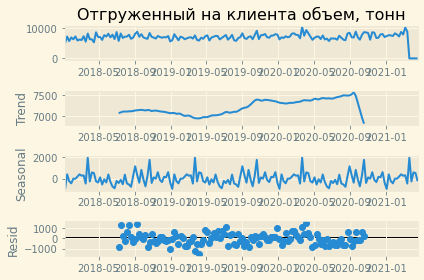

In [3]:
components = sm.tsa.seasonal_decompose(df)
components.plot()
plt.show()

# trend= components.trend
# seasonality= components.seasonal
# remainder= components.resid

<AxesSubplot:xlabel='Год_неделя'>

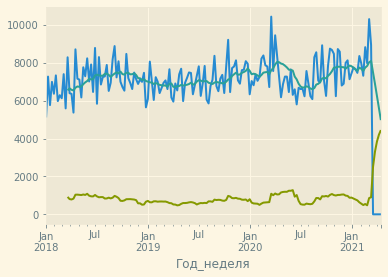

In [4]:
df.plot()
df.rolling(window=12).mean().plot()
df.rolling(window=12).std().plot()

In [5]:
ad_fuller_test = sm.tsa.stattools.adfuller(df[:-5], autolag='AIC')
ad_fuller_test
# p-value = 0.1247981361438551 > 0,05, данные ряда не стационарны

(-2.462767563822535,
 0.1247981361438551,
 12,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 2474.406898153245)

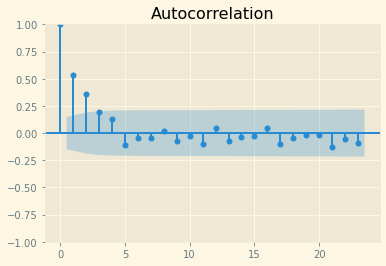

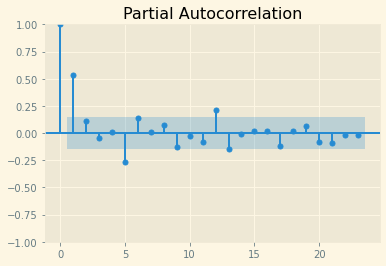

In [6]:
plot_acf(df)
plt.show()

plot_pacf(df)
plt.show()

In [7]:
Arima_model=pm.auto_arima(df[:-5], start_p=0, start_q=0, max_p=3, max_q=3, start_P=0, start_Q=0, max_P=3, max_Q=3, 
                          m=52, stepwise=True, seasonal=True, information_criterion='aic', trace=True, d=1, D=1, 
                          error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1979.201, Time=0.42 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1922.007, Time=8.60 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=15.86 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=1945.191, Time=0.30 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=23.65 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=23.94 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=14.58 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=66.20 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=5.99 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=1907.510, Time=12.87 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=1937.473, Time=0.43 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=inf, Time=31.93 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=32.85 sec
 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=24.25 sec
 ARIMA(2,1,0)(2,1,1)[52]             : AIC=inf, Time=71

In [13]:
df[-5:]

Год_неделя
2021-03-21    0.0
2021-03-28    0.0
2021-04-04    0.0
2021-04-11    0.0
2021-04-18    0.0
Name: Отгруженный на клиента объем, тонн, dtype: float64

In [14]:
arima_predictions = pd.DataFrame(Arima_model.predict(n_periods=len(df), X=df[-5:]))
arima_predictions = np.array(arima_predictions)
arima_predictions = arima_predictions.reshape(len(df),-1)
arima_predictions = pd.DataFrame(arima_predictions, columns = ['Arima_predictions'])
arima_predictions.head()

,Arima_predictions
0,9782.548230
1,8799.594743
2,8735.619405
3,8481.977781
4,9322.220260


In [15]:
Arima_MAPE = mean_absolute_percentage_error(arima_predictions, df)*100
Arima_MAPE

28.81731426683117

In [16]:
df_vis = pd.concat([df.reset_index(drop=True), arima_predictions], axis = 1)

<AxesSubplot:>

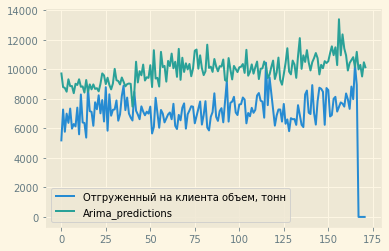

In [17]:
df_vis.plot()

## Holt-Winters

In [14]:
import statsmodels as sm
sm.tsa.holtwinters.ExponentialSmoothing

model_expo1 = sm.tsa.holtwinters.ExponentialSmoothing(df[:-5],trend = 'add',
                                                      seasonal = 'add', seasonal_periods=52)
model_expo2 = sm.tsa.holtwinters.ExponentialSmoothing(df[:-5],trend = 'mul',
                                                      seasonal = 'add', seasonal_periods=52)
model_expo3 = sm.tsa.holtwinters.ExponentialSmoothing(df[:-5],trend = 'add',
                                                      seasonal = 'mul', seasonal_periods=52)
model_expo4 = sm.tsa.holtwinters.ExponentialSmoothing(df[:-5],trend = 'mul',
                                                      seasonal = 'mul', seasonal_periods=52)

results_1 = model_expo1.fit()
results_2 = model_expo2.fit()
results_3 = model_expo3.fit()
results_4 = model_expo4.fit()

results_1.summary()
results_2.summary()
results_3.summary()
results_4.summary()


HoltWinters1 = model_expo1.fit().predict(0, len(df)-1)
HoltWinters2 = model_expo2.fit().predict(0, len(df)-1)
HoltWinters3 = model_expo3.fit().predict(0, len(df)-1)
HoltWinters4 = model_expo4.fit().predict(0, len(df)-1)

HoltWinters_MAPE1 = mean_absolute_percentage_error(HoltWinters1, df)*100
HoltWinters_MAPE2 = mean_absolute_percentage_error(HoltWinters2, df)*100
HoltWinters_MAPE3 = mean_absolute_percentage_error(HoltWinters3, df)*100
HoltWinters_MAPE4 = mean_absolute_percentage_error(HoltWinters4, df)*100

In [15]:
print(HoltWinters_MAPE1)
print(HoltWinters_MAPE2)
print(HoltWinters_MAPE3)
print(HoltWinters_MAPE4)

10.282082306666174
12.081301982237745
10.116247061565305
12.563363428541813


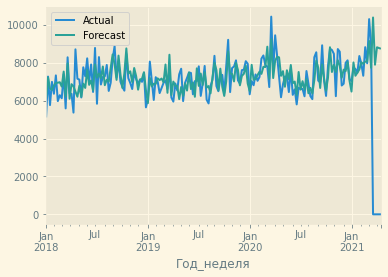

In [17]:
# Вариант модели model_expo3 показывает лучшие результаты по точности, включая ARIMA.
HoltWinters_predictions = model_expo3.fit().predict(0, len(df)-1)

df.plot(label = 'Actual')
HoltWinters3.plot(label = 'Forecast')
plt.legend(loc='upper left')

## LSTM

In [18]:
import torch
import torch.nn as nn
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [19]:
y = df.values.astype(float)

test_size = 52

train_set = y[:-test_size]
test_set = y[-test_size:]

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

# Нормализуем данные
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [21]:
train_norm = torch.FloatTensor(train_norm).view(-1)
window_size = 5   

def input_data(seq,ws):
    out = [] 
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

train_data = input_data(train_norm,window_size)
len(train_data)

115

In [22]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Flly-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),    
                       torch.zeros(1,1,self.hidden_size))
                                           
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [23]:
torch.manual_seed(101)
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [24]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


In [25]:
epochs = 4000

import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data:
        
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {(time.time() - start_time)/60:.0f} minutes')

Epoch:  1 Loss: 0.01630978
Epoch:  2 Loss: 0.01617927
Epoch:  3 Loss: 0.01626283
Epoch:  4 Loss: 0.01653322
Epoch:  5 Loss: 0.01692122
Epoch:  6 Loss: 0.01757238
Epoch:  7 Loss: 0.01842203
Epoch:  8 Loss: 0.01945185
Epoch:  9 Loss: 0.02069972
Epoch: 10 Loss: 0.02219287
Epoch: 11 Loss: 0.02394938
Epoch: 12 Loss: 0.02602081
Epoch: 13 Loss: 0.02845728
Epoch: 14 Loss: 0.03130206
Epoch: 15 Loss: 0.03460008
Epoch: 16 Loss: 0.03836461
Epoch: 17 Loss: 0.04256404
Epoch: 18 Loss: 0.04717182
Epoch: 19 Loss: 0.05215656
Epoch: 20 Loss: 0.05752824
Epoch: 21 Loss: 0.06314248
Epoch: 22 Loss: 0.06888103
Epoch: 23 Loss: 0.07458997
Epoch: 24 Loss: 0.08031037
Epoch: 25 Loss: 0.08534919
Epoch: 26 Loss: 0.08970015
Epoch: 27 Loss: 0.09186841
Epoch: 28 Loss: 0.09142654
Epoch: 29 Loss: 0.08710058
Epoch: 30 Loss: 0.07604325
Epoch: 31 Loss: 0.06165682
Epoch: 32 Loss: 0.04435095
Epoch: 33 Loss: 0.03046388
Epoch: 34 Loss: 0.02163885
Epoch: 35 Loss: 0.01791790
Epoch: 36 Loss: 0.01947053
Epoch: 37 Loss: 0.02251572
E

Epoch: 298 Loss: 0.00013904
Epoch: 299 Loss: 0.00012314
Epoch: 300 Loss: 0.00274155
Epoch: 301 Loss: 0.00017262
Epoch: 302 Loss: 0.00300528
Epoch: 303 Loss: 0.00136015
Epoch: 304 Loss: 0.00115510
Epoch: 305 Loss: 0.00051083
Epoch: 306 Loss: 0.00135388
Epoch: 307 Loss: 0.00071794
Epoch: 308 Loss: 0.00000135
Epoch: 309 Loss: 0.00033274
Epoch: 310 Loss: 0.00039470
Epoch: 311 Loss: 0.00507725
Epoch: 312 Loss: 0.00383482
Epoch: 313 Loss: 0.00533594
Epoch: 314 Loss: 0.00101533
Epoch: 315 Loss: 0.00014825
Epoch: 316 Loss: 0.00532816
Epoch: 317 Loss: 0.00000047
Epoch: 318 Loss: 0.00004100
Epoch: 319 Loss: 0.00034026
Epoch: 320 Loss: 0.00000518
Epoch: 321 Loss: 0.00003651
Epoch: 322 Loss: 0.00000000
Epoch: 323 Loss: 0.00000343
Epoch: 324 Loss: 0.00000929
Epoch: 325 Loss: 0.00013739
Epoch: 326 Loss: 0.00003985
Epoch: 327 Loss: 0.00001558
Epoch: 328 Loss: 0.00060053
Epoch: 329 Loss: 0.00003756
Epoch: 330 Loss: 0.00150159
Epoch: 331 Loss: 0.00291778
Epoch: 332 Loss: 0.00694789
Epoch: 333 Loss: 0.0

Epoch: 591 Loss: 0.00000986
Epoch: 592 Loss: 0.00339435
Epoch: 593 Loss: 0.00019392
Epoch: 594 Loss: 0.00225291
Epoch: 595 Loss: 0.00105361
Epoch: 596 Loss: 0.00007922
Epoch: 597 Loss: 0.00010026
Epoch: 598 Loss: 0.00005239
Epoch: 599 Loss: 0.00000524
Epoch: 600 Loss: 0.00000019
Epoch: 601 Loss: 0.00000308
Epoch: 602 Loss: 0.00000234
Epoch: 603 Loss: 0.00000146
Epoch: 604 Loss: 0.00000057
Epoch: 605 Loss: 0.00000030
Epoch: 606 Loss: 0.00000021
Epoch: 607 Loss: 0.00000025
Epoch: 608 Loss: 0.00000030
Epoch: 609 Loss: 0.00000020
Epoch: 610 Loss: 0.00000006
Epoch: 611 Loss: 0.00000046
Epoch: 612 Loss: 0.00000110
Epoch: 613 Loss: 0.00000238
Epoch: 614 Loss: 0.00000112
Epoch: 615 Loss: 0.00000026
Epoch: 616 Loss: 0.00000795
Epoch: 617 Loss: 0.00004531
Epoch: 618 Loss: 0.00000044
Epoch: 619 Loss: 0.00008274
Epoch: 620 Loss: 0.00099820
Epoch: 621 Loss: 0.00107369
Epoch: 622 Loss: 0.00122169
Epoch: 623 Loss: 0.00023460
Epoch: 624 Loss: 0.00060032
Epoch: 625 Loss: 0.00045280
Epoch: 626 Loss: 0.0

Epoch: 884 Loss: 0.00000000
Epoch: 885 Loss: 0.00000000
Epoch: 886 Loss: 0.00000000
Epoch: 887 Loss: 0.00000000
Epoch: 888 Loss: 0.00000000
Epoch: 889 Loss: 0.00000006
Epoch: 890 Loss: 0.00000002
Epoch: 891 Loss: 0.00000317
Epoch: 892 Loss: 0.00013255
Epoch: 893 Loss: 0.00563719
Epoch: 894 Loss: 0.00757773
Epoch: 895 Loss: 0.00106366
Epoch: 896 Loss: 0.00048441
Epoch: 897 Loss: 0.00034720
Epoch: 898 Loss: 0.00000757
Epoch: 899 Loss: 0.00001315
Epoch: 900 Loss: 0.00003337
Epoch: 901 Loss: 0.00000050
Epoch: 902 Loss: 0.00004600
Epoch: 903 Loss: 0.00003327
Epoch: 904 Loss: 0.00001765
Epoch: 905 Loss: 0.00000371
Epoch: 906 Loss: 0.00001085
Epoch: 907 Loss: 0.00000889
Epoch: 908 Loss: 0.00000016
Epoch: 909 Loss: 0.00000060
Epoch: 910 Loss: 0.00000419
Epoch: 911 Loss: 0.00007076
Epoch: 912 Loss: 0.00000037
Epoch: 913 Loss: 0.00045390
Epoch: 914 Loss: 0.00000422
Epoch: 915 Loss: 0.00028825
Epoch: 916 Loss: 0.00018922
Epoch: 917 Loss: 0.00010896
Epoch: 918 Loss: 0.00011715
Epoch: 919 Loss: 0.0

Epoch: 1171 Loss: 0.00000000
Epoch: 1172 Loss: 0.00007003
Epoch: 1173 Loss: 0.00007338
Epoch: 1174 Loss: 0.00003775
Epoch: 1175 Loss: 0.00040864
Epoch: 1176 Loss: 0.00071355
Epoch: 1177 Loss: 0.00044758
Epoch: 1178 Loss: 0.00288569
Epoch: 1179 Loss: 0.00000574
Epoch: 1180 Loss: 0.00042825
Epoch: 1181 Loss: 0.00000175
Epoch: 1182 Loss: 0.00000007
Epoch: 1183 Loss: 0.00002223
Epoch: 1184 Loss: 0.00000040
Epoch: 1185 Loss: 0.00010202
Epoch: 1186 Loss: 0.00006760
Epoch: 1187 Loss: 0.00025635
Epoch: 1188 Loss: 0.00022896
Epoch: 1189 Loss: 0.00014907
Epoch: 1190 Loss: 0.00004442
Epoch: 1191 Loss: 0.00000341
Epoch: 1192 Loss: 0.00036657
Epoch: 1193 Loss: 0.00014935
Epoch: 1194 Loss: 0.00000541
Epoch: 1195 Loss: 0.00000645
Epoch: 1196 Loss: 0.00001227
Epoch: 1197 Loss: 0.00004763
Epoch: 1198 Loss: 0.00002205
Epoch: 1199 Loss: 0.00012526
Epoch: 1200 Loss: 0.00020513
Epoch: 1201 Loss: 0.00022264
Epoch: 1202 Loss: 0.00000027
Epoch: 1203 Loss: 0.00002864
Epoch: 1204 Loss: 0.00003073
Epoch: 1205 Lo

Epoch: 1454 Loss: 0.00008169
Epoch: 1455 Loss: 0.00000560
Epoch: 1456 Loss: 0.00000579
Epoch: 1457 Loss: 0.00030894
Epoch: 1458 Loss: 0.00000000
Epoch: 1459 Loss: 0.00000808
Epoch: 1460 Loss: 0.00016536
Epoch: 1461 Loss: 0.00021936
Epoch: 1462 Loss: 0.00003371
Epoch: 1463 Loss: 0.00004597
Epoch: 1464 Loss: 0.00001615
Epoch: 1465 Loss: 0.00007752
Epoch: 1466 Loss: 0.00002245
Epoch: 1467 Loss: 0.00012595
Epoch: 1468 Loss: 0.00008086
Epoch: 1469 Loss: 0.00000167
Epoch: 1470 Loss: 0.00008957
Epoch: 1471 Loss: 0.00000001
Epoch: 1472 Loss: 0.00000053
Epoch: 1473 Loss: 0.00012298
Epoch: 1474 Loss: 0.00005044
Epoch: 1475 Loss: 0.00007472
Epoch: 1476 Loss: 0.00002263
Epoch: 1477 Loss: 0.00004113
Epoch: 1478 Loss: 0.00003462
Epoch: 1479 Loss: 0.00000018
Epoch: 1480 Loss: 0.00022338
Epoch: 1481 Loss: 0.00028895
Epoch: 1482 Loss: 0.00000357
Epoch: 1483 Loss: 0.00016327
Epoch: 1484 Loss: 0.00009405
Epoch: 1485 Loss: 0.00003680
Epoch: 1486 Loss: 0.00003469
Epoch: 1487 Loss: 0.00003224
Epoch: 1488 Lo

Epoch: 1737 Loss: 0.00000748
Epoch: 1738 Loss: 0.00000986
Epoch: 1739 Loss: 0.00000096
Epoch: 1740 Loss: 0.00007380
Epoch: 1741 Loss: 0.00005358
Epoch: 1742 Loss: 0.00027647
Epoch: 1743 Loss: 0.00009000
Epoch: 1744 Loss: 0.00002287
Epoch: 1745 Loss: 0.00024268
Epoch: 1746 Loss: 0.00004808
Epoch: 1747 Loss: 0.00018954
Epoch: 1748 Loss: 0.00000025
Epoch: 1749 Loss: 0.00000065
Epoch: 1750 Loss: 0.00001192
Epoch: 1751 Loss: 0.00013706
Epoch: 1752 Loss: 0.00001132
Epoch: 1753 Loss: 0.00003017
Epoch: 1754 Loss: 0.00000084
Epoch: 1755 Loss: 0.00005400
Epoch: 1756 Loss: 0.00001119
Epoch: 1757 Loss: 0.00000201
Epoch: 1758 Loss: 0.00016569
Epoch: 1759 Loss: 0.00000153
Epoch: 1760 Loss: 0.00000619
Epoch: 1761 Loss: 0.00003450
Epoch: 1762 Loss: 0.00009521
Epoch: 1763 Loss: 0.00001921
Epoch: 1764 Loss: 0.00000024
Epoch: 1765 Loss: 0.00013650
Epoch: 1766 Loss: 0.00014999
Epoch: 1767 Loss: 0.00004927
Epoch: 1768 Loss: 0.00000153
Epoch: 1769 Loss: 0.00001317
Epoch: 1770 Loss: 0.00000389
Epoch: 1771 Lo

Epoch: 2020 Loss: 0.00000000
Epoch: 2021 Loss: 0.00000000
Epoch: 2022 Loss: 0.00000001
Epoch: 2023 Loss: 0.00000001
Epoch: 2024 Loss: 0.00000009
Epoch: 2025 Loss: 0.00000001
Epoch: 2026 Loss: 0.00000002
Epoch: 2027 Loss: 0.00000417
Epoch: 2028 Loss: 0.00004249
Epoch: 2029 Loss: 0.00005903
Epoch: 2030 Loss: 0.00012609
Epoch: 2031 Loss: 0.00066427
Epoch: 2032 Loss: 0.00002089
Epoch: 2033 Loss: 0.00005184
Epoch: 2034 Loss: 0.00000365
Epoch: 2035 Loss: 0.00004142
Epoch: 2036 Loss: 0.00000194
Epoch: 2037 Loss: 0.00002714
Epoch: 2038 Loss: 0.00000179
Epoch: 2039 Loss: 0.00000140
Epoch: 2040 Loss: 0.00000006
Epoch: 2041 Loss: 0.00000004
Epoch: 2042 Loss: 0.00000445
Epoch: 2043 Loss: 0.00000114
Epoch: 2044 Loss: 0.00001476
Epoch: 2045 Loss: 0.00004195
Epoch: 2046 Loss: 0.00008955
Epoch: 2047 Loss: 0.00018090
Epoch: 2048 Loss: 0.00067675
Epoch: 2049 Loss: 0.00047061
Epoch: 2050 Loss: 0.00000034
Epoch: 2051 Loss: 0.00001710
Epoch: 2052 Loss: 0.00000027
Epoch: 2053 Loss: 0.00014993
Epoch: 2054 Lo

Epoch: 2303 Loss: 0.00000341
Epoch: 2304 Loss: 0.00000646
Epoch: 2305 Loss: 0.00001650
Epoch: 2306 Loss: 0.00000074
Epoch: 2307 Loss: 0.00000758
Epoch: 2308 Loss: 0.00000001
Epoch: 2309 Loss: 0.00010189
Epoch: 2310 Loss: 0.00001353
Epoch: 2311 Loss: 0.00012247
Epoch: 2312 Loss: 0.00010572
Epoch: 2313 Loss: 0.00000407
Epoch: 2314 Loss: 0.00020391
Epoch: 2315 Loss: 0.00000148
Epoch: 2316 Loss: 0.00000339
Epoch: 2317 Loss: 0.00002039
Epoch: 2318 Loss: 0.00000393
Epoch: 2319 Loss: 0.00002694
Epoch: 2320 Loss: 0.00000973
Epoch: 2321 Loss: 0.00000038
Epoch: 2322 Loss: 0.00000384
Epoch: 2323 Loss: 0.00000260
Epoch: 2324 Loss: 0.00000327
Epoch: 2325 Loss: 0.00000005
Epoch: 2326 Loss: 0.00000128
Epoch: 2327 Loss: 0.00002049
Epoch: 2328 Loss: 0.00007594
Epoch: 2329 Loss: 0.00002444
Epoch: 2330 Loss: 0.00000069
Epoch: 2331 Loss: 0.00000062
Epoch: 2332 Loss: 0.00010399
Epoch: 2333 Loss: 0.00057563
Epoch: 2334 Loss: 0.00000419
Epoch: 2335 Loss: 0.00022808
Epoch: 2336 Loss: 0.00001960
Epoch: 2337 Lo

Epoch: 2586 Loss: 0.00000889
Epoch: 2587 Loss: 0.00000331
Epoch: 2588 Loss: 0.00000527
Epoch: 2589 Loss: 0.00001173
Epoch: 2590 Loss: 0.00000530
Epoch: 2591 Loss: 0.00000292
Epoch: 2592 Loss: 0.00022306
Epoch: 2593 Loss: 0.00025453
Epoch: 2594 Loss: 0.00007962
Epoch: 2595 Loss: 0.00002059
Epoch: 2596 Loss: 0.00007690
Epoch: 2597 Loss: 0.00001029
Epoch: 2598 Loss: 0.00000249
Epoch: 2599 Loss: 0.00000003
Epoch: 2600 Loss: 0.00000595
Epoch: 2601 Loss: 0.00000308
Epoch: 2602 Loss: 0.00001368
Epoch: 2603 Loss: 0.00001408
Epoch: 2604 Loss: 0.00000249
Epoch: 2605 Loss: 0.00000139
Epoch: 2606 Loss: 0.00000064
Epoch: 2607 Loss: 0.00004242
Epoch: 2608 Loss: 0.00003976
Epoch: 2609 Loss: 0.00000082
Epoch: 2610 Loss: 0.00000089
Epoch: 2611 Loss: 0.00003942
Epoch: 2612 Loss: 0.00001212
Epoch: 2613 Loss: 0.00002473
Epoch: 2614 Loss: 0.00000376
Epoch: 2615 Loss: 0.00007777
Epoch: 2616 Loss: 0.00005136
Epoch: 2617 Loss: 0.00000183
Epoch: 2618 Loss: 0.00000033
Epoch: 2619 Loss: 0.00001051
Epoch: 2620 Lo

Epoch: 2869 Loss: 0.00000398
Epoch: 2870 Loss: 0.00006455
Epoch: 2871 Loss: 0.00000065
Epoch: 2872 Loss: 0.00000094
Epoch: 2873 Loss: 0.00002686
Epoch: 2874 Loss: 0.00008861
Epoch: 2875 Loss: 0.00002003
Epoch: 2876 Loss: 0.00000061
Epoch: 2877 Loss: 0.00000996
Epoch: 2878 Loss: 0.00002015
Epoch: 2879 Loss: 0.00000103
Epoch: 2880 Loss: 0.00000240
Epoch: 2881 Loss: 0.00014366
Epoch: 2882 Loss: 0.00000000
Epoch: 2883 Loss: 0.00000284
Epoch: 2884 Loss: 0.00000811
Epoch: 2885 Loss: 0.00000289
Epoch: 2886 Loss: 0.00000442
Epoch: 2887 Loss: 0.00000227
Epoch: 2888 Loss: 0.00000171
Epoch: 2889 Loss: 0.00000065
Epoch: 2890 Loss: 0.00000020
Epoch: 2891 Loss: 0.00000002
Epoch: 2892 Loss: 0.00000013
Epoch: 2893 Loss: 0.00000053
Epoch: 2894 Loss: 0.00000064
Epoch: 2895 Loss: 0.00000074
Epoch: 2896 Loss: 0.00000026
Epoch: 2897 Loss: 0.00000037
Epoch: 2898 Loss: 0.00000001
Epoch: 2899 Loss: 0.00000017
Epoch: 2900 Loss: 0.00000151
Epoch: 2901 Loss: 0.00000580
Epoch: 2902 Loss: 0.00002357
Epoch: 2903 Lo

Epoch: 3152 Loss: 0.00000049
Epoch: 3153 Loss: 0.00004469
Epoch: 3154 Loss: 0.00002657
Epoch: 3155 Loss: 0.00002685
Epoch: 3156 Loss: 0.00004391
Epoch: 3157 Loss: 0.00006710
Epoch: 3158 Loss: 0.00002018
Epoch: 3159 Loss: 0.00000071
Epoch: 3160 Loss: 0.00003510
Epoch: 3161 Loss: 0.00004321
Epoch: 3162 Loss: 0.00001858
Epoch: 3163 Loss: 0.00012458
Epoch: 3164 Loss: 0.00037950
Epoch: 3165 Loss: 0.00002928
Epoch: 3166 Loss: 0.00000331
Epoch: 3167 Loss: 0.00000062
Epoch: 3168 Loss: 0.00000013
Epoch: 3169 Loss: 0.00000015
Epoch: 3170 Loss: 0.00000001
Epoch: 3171 Loss: 0.00000004
Epoch: 3172 Loss: 0.00000010
Epoch: 3173 Loss: 0.00000000
Epoch: 3174 Loss: 0.00000028
Epoch: 3175 Loss: 0.00000066
Epoch: 3176 Loss: 0.00000114
Epoch: 3177 Loss: 0.00000114
Epoch: 3178 Loss: 0.00000068
Epoch: 3179 Loss: 0.00000019
Epoch: 3180 Loss: 0.00000000
Epoch: 3181 Loss: 0.00000028
Epoch: 3182 Loss: 0.00000082
Epoch: 3183 Loss: 0.00000107
Epoch: 3184 Loss: 0.00000009
Epoch: 3185 Loss: 0.00000137
Epoch: 3186 Lo

Epoch: 3435 Loss: 0.00000443
Epoch: 3436 Loss: 0.00000143
Epoch: 3437 Loss: 0.00000061
Epoch: 3438 Loss: 0.00000232
Epoch: 3439 Loss: 0.00000406
Epoch: 3440 Loss: 0.00000340
Epoch: 3441 Loss: 0.00000140
Epoch: 3442 Loss: 0.00000027
Epoch: 3443 Loss: 0.00000005
Epoch: 3444 Loss: 0.00000014
Epoch: 3445 Loss: 0.00000266
Epoch: 3446 Loss: 0.00000001
Epoch: 3447 Loss: 0.00001311
Epoch: 3448 Loss: 0.00000340
Epoch: 3449 Loss: 0.00004668
Epoch: 3450 Loss: 0.00001214
Epoch: 3451 Loss: 0.00006873
Epoch: 3452 Loss: 0.00012166
Epoch: 3453 Loss: 0.00001115
Epoch: 3454 Loss: 0.00001083
Epoch: 3455 Loss: 0.00000154
Epoch: 3456 Loss: 0.00000088
Epoch: 3457 Loss: 0.00006966
Epoch: 3458 Loss: 0.00000075
Epoch: 3459 Loss: 0.00000164
Epoch: 3460 Loss: 0.00002044
Epoch: 3461 Loss: 0.00000156
Epoch: 3462 Loss: 0.00000941
Epoch: 3463 Loss: 0.00000400
Epoch: 3464 Loss: 0.00000218
Epoch: 3465 Loss: 0.00000618
Epoch: 3466 Loss: 0.00000211
Epoch: 3467 Loss: 0.00004309
Epoch: 3468 Loss: 0.00000021
Epoch: 3469 Lo

Epoch: 3718 Loss: 0.00000143
Epoch: 3719 Loss: 0.00004160
Epoch: 3720 Loss: 0.00000106
Epoch: 3721 Loss: 0.00000021
Epoch: 3722 Loss: 0.00000097
Epoch: 3723 Loss: 0.00000006
Epoch: 3724 Loss: 0.00000004
Epoch: 3725 Loss: 0.00000003
Epoch: 3726 Loss: 0.00000174
Epoch: 3727 Loss: 0.00000074
Epoch: 3728 Loss: 0.00001363
Epoch: 3729 Loss: 0.00000567
Epoch: 3730 Loss: 0.00004339
Epoch: 3731 Loss: 0.00005444
Epoch: 3732 Loss: 0.00004939
Epoch: 3733 Loss: 0.00000058
Epoch: 3734 Loss: 0.00007832
Epoch: 3735 Loss: 0.00001433
Epoch: 3736 Loss: 0.00002230
Epoch: 3737 Loss: 0.00000232
Epoch: 3738 Loss: 0.00000086
Epoch: 3739 Loss: 0.00000041
Epoch: 3740 Loss: 0.00000130
Epoch: 3741 Loss: 0.00000259
Epoch: 3742 Loss: 0.00000253
Epoch: 3743 Loss: 0.00000018
Epoch: 3744 Loss: 0.00000000
Epoch: 3745 Loss: 0.00000037
Epoch: 3746 Loss: 0.00000055
Epoch: 3747 Loss: 0.00000213
Epoch: 3748 Loss: 0.00000110
Epoch: 3749 Loss: 0.00000028
Epoch: 3750 Loss: 0.00000026
Epoch: 3751 Loss: 0.00000156
Epoch: 3752 Lo

In [26]:
future = len(df) 

preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [27]:
lstm_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
lstm_predictions = pd.DataFrame(lstm_predictions, columns = ['LSTM_predictions'])
lstm_predictions.head()

,LSTM_predictions
0,8355.632970
1,8263.014714
2,8861.402331
3,8011.482258
4,6864.422741


In [28]:
LSTM_MAPE = mean_absolute_percentage_error(lstm_predictions, df)*100
LSTM_MAPE

15.40091633702199

In [29]:
df_vis = pd.concat([df.reset_index(drop=True), lstm_predictions], axis = 1)

<AxesSubplot:>

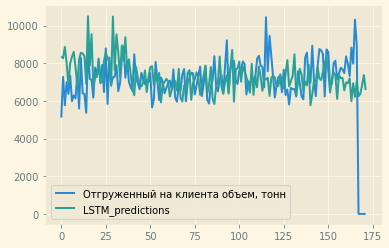

In [30]:
df_vis.plot()

In [104]:
print('Arima MAPE: %f' % Arima_MAPE)
print('HoltWinters MAPE: %f' % HoltWinters_MAPE3)
print('LSTM MAPE: %f' % LSTM_MAPE)

Arima MAPE: 28.209620
HoltWinters MAPE: 10.116247
LSTM MAPE: 15.056327


# Модель прогнозирования HoltWinters №3 имеет наименшую ошибку MAPE, следовательно, её прогнозы на 5 недель, берём за оптимальные.

In [34]:
HoltWinters_predictions[-5:]

2021-03-21    10396.846358
2021-03-28     7902.758147
2021-04-04     8823.010868
2021-04-11     8785.594855
2021-04-18     8745.477094
Freq: W-SUN, dtype: float64